<a href="https://colab.research.google.com/github/blessingitodo/A-B-Testing/blob/main/STP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/DEAP/deap@master

  Cloning https://github.com/DEAP/deap (to revision master) to /tmp/pip-req-build-jo8do179
  Running command git clone --filter=blob:none --quiet https://github.com/DEAP/deap /tmp/pip-req-build-jo8do179
  Resolved https://github.com/DEAP/deap to commit 1dc8d28ec06d44cda01bfa86c1c02b49fcc1969d
  Preparing metadata (setup.py) ... done


**Import libraries needed for Analysis**

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

**Import Plot Data needed for Analysis**

In [3]:
plotA = pd.read_excel('WebPlotDigitizer - PlotA.xlsx', sheet_name=None)
plotB = pd.read_excel('WebPlotDigitizer - PlotB.xlsx', sheet_name=None)
plotC = pd.read_excel('WebPlotDigitizer - PlotC.xlsx', sheet_name=None)
plotD = pd.read_excel('WebPlotDigitizer - PlotD.xlsx', sheet_name=None)

freq_colors = {"100Hz": "red", "50Hz": "brown", "20Hz": "green", "10Hz": "blue", "5Hz": "cyan"}

plotA.keys()
plotB.keys()
plotC.keys()
plotD.keys()

dict_keys(['100Hz', '50Hz', '20Hz', '10Hz', '5Hz'])

In [4]:
def _fix_plot(plot):
  for k, pl in plot.items():

    freq = int(k.replace('Hz', '')) # extract frequency from the key

    # 1 / freq is equals to the interval between pulses
    # then it is multiplied by 1000 for converting from s to ms
    pl['Time(s)'] = np.arange(0, pl.shape[0], 1) / freq

_fix_plot(plotA)
_fix_plot(plotB)
_fix_plot(plotC)
_fix_plot(plotD)

**Define Function for Short Term Plasticity Graph and Call Function for all 4 graphs**

In [5]:
def short_term_plasticity_graph(plot, plot_name):
  """
  Generate a scatter plot with line connections showing short-term synaptic plasticity data.

  Parameters
  ----------
  plot : dict
      A dictionary where keys are frequency labels (e.g., '10Hz', '20Hz') and values are
      pandas DataFrames. Each DataFrame must contain:
          - 'Time(s)': float, time points in seconds
          - 'Norm EPSC amp': float, normalized EPSC amplitude values

  plot_name : str
      The title to display at the top of the plot.

  freq_colors : dict
      A dictionary mapping frequency labels to color values.
      Example: {'10Hz': 'blue', '20Hz': 'red', '50Hz': 'green'}

  ...
  """
  for sheet, df in plot.items():
    plt.scatter(df["Time(s)"], df["Norm EPSC amp"], s=20, color=freq_colors[sheet], alpha=0.7, label=f"{sheet}")
    plt.plot(df["Time(s)"], df["Norm EPSC amp"], color=freq_colors[sheet], alpha=0.8)

  plt.title(f"{plot_name}")
  plt.xlabel('Time(s)')
  plt.ylabel('Norm EPSC amp')

  plt.yticks([0, 1, 2, 3, 4])
  plt.xticks([0, 0.5, 1])

  plt.axhline(1, color="black", linestyle="--", linewidth=1)

  plt.legend()
  plt.show()

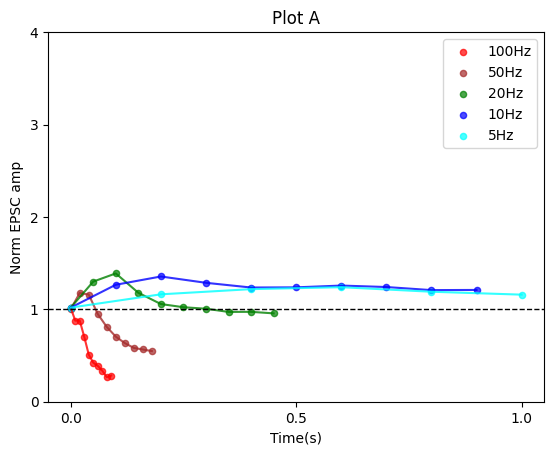

In [6]:
short_term_plasticity_graph(plotA, "Plot A")

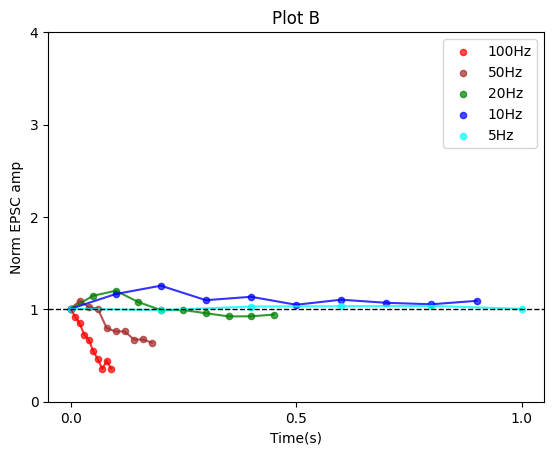

In [7]:
short_term_plasticity_graph(plotB, "Plot B")

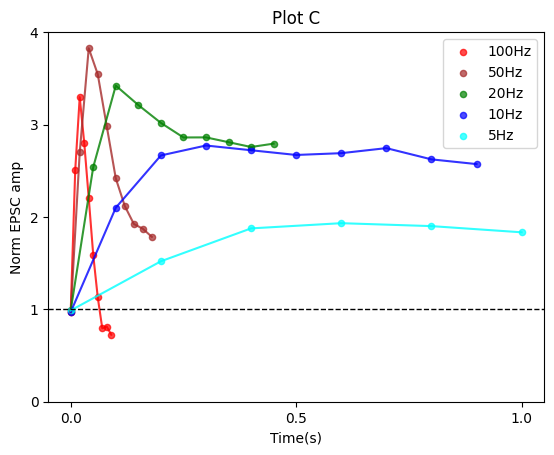

In [8]:
short_term_plasticity_graph(plotC, "Plot C")

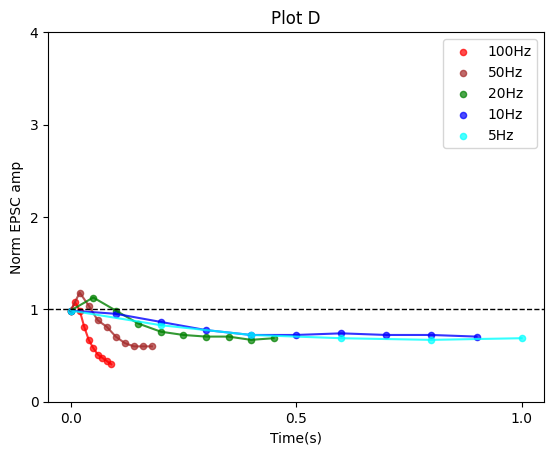

In [9]:
short_term_plasticity_graph(plotD, "Plot D")

**The Markram Synaptic Response Model**

Using the following steps to implement the makram model


*   Define the makram model and Fitness function
*   Set up DEAP algorithm and integrate into the solution using the following steps:
    * Define the Fitness and Individual
    * Define the ToolBox
    * Create the individual and define the parameter bounds
    * Register the fitness function and the other operators
*   Run the Algorithm
*   Plot Makram model simulation with experiment's plasticity
*   Extract the top 10 best Solutions




In [10]:
def _markram_model(params, times):
  """
  Simulate short-term synaptic plasticity using the Markram model.

  The Markram model describes synaptic dynamics through two key variables:
  - R: Available resources (vesicle pool)
  - u: Utilization of resources (release probability)

  Parameters
  ----------
  params : tuple of float
      Model parameters (U, tau_rec, tau_facil) where:
          - U : float
              Baseline release probability (0 < U < 1)
          - tau_rec : float
              Recovery time constant in milliseconds (ms)
          - tau_facil : float
              Facilitation time constant in milliseconds (ms)

  times : array-like
      Time points in milliseconds at which to evaluate the model.
      Should correspond to stimulus times.

  Returns
  -------
  numpy.ndarray
      Normalized EPSC amplitudes at each time point. The first value is
      normalized to 1.0, subsequent values show relative changes.

  Notes
  -----
  - Time must be provided in milliseconds
  - Returns normalized values (first EPSC = 1.0)
  - Uses exponential decay for both facilitation and recovery processes

  References
  ----------
  Markram H, Wang Y, Tsodyks M (1998). "Differential signaling via the same
  axon of neocortical pyramidal neurons." PNAS 95(9): 5323-5328.

  Examples
  --------
  >>> params = (0.5, 800, 20)  # U, tau_rec, tau_facil
  >>> times = np.array([0, 100, 200, 300])  # in ms
  >>> epsc = _markram_model(params, times)
  """
  U, tau_rec, tau_facil = params
  dt = np.diff(times, prepend=times[0])
  n = len(times)

  R = np.zeros(n)
  u = np.zeros(n)
  EPSC = np.zeros(n)

  # initial conditions
  u[0] = U + U * (1 - U)
  R[0] = (1 - U) * (1 - u[0])
  EPSC[0] = R[0] * u[0]

  for i in range(1, n):
      u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
      R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
      EPSC[i] = R[i] * u[i]

  return EPSC / EPSC[0]

def fitness_markram(params, plot):
  """
  Calculate fitness (error) of Markram model parameters against experimental data.

  This function evaluates how well a set of Markram model parameters fit
  experimental EPSC data by computing the mean squared error across multiple
  frequency conditions.

  Parameters
  ----------
  params : tuple of float
      Model parameters (U, tau_rec, tau_facil) to evaluate.
      See _markram_model for parameter descriptions.

  plot : dict
      Dictionary where keys are condition labels (e.g., '10Hz', '20Hz') and
      values are pandas DataFrames containing:
          - 'Time(s)': float, time points in seconds
          - 'Norm EPSC amp': float, normalized experimental EPSC amplitudes

  Returns
  -------
  float
      Mean squared error averaged across all conditions. Lower values indicate
      better fit to experimental data.

  Notes
  -----
  - Converts time from seconds to milliseconds internally
  - Computes MSE for each condition separately, then returns overall mean
  - Used as objective function for parameter optimization (e.g., with DEAP)

  Examples
  --------
  >>> import pandas as pd
  >>> params = (0.5, 800, 20)
  >>> data = {
  ...     '10Hz': pd.DataFrame({
  ...         'Time(s)': [0, 0.1, 0.2],
  ...         'Norm EPSC amp': [1.0, 1.1, 1.05]
  ...     })
  ... }
  >>> error = fitness_markram(params, data)
  >>> print(f"Model error: {error:.4f}")
  """
  all_diff = []

  for _plot in plot.values():
      times = _plot['Time(s)'].values
      exp_epsc_amps = _plot['Norm EPSC amp'].values

      sim_epsc_amps = _markram_model(params, times * 1000)

      diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)

      all_diff.append(diff)
  return float(np.mean(all_diff))

In [11]:
# test
fitness_markram([0.7, 800, 10000], plotA)

12.569148132369161

In [12]:
def toolbox():
  """
  Set up DEAP toolbox for optimizing Markram model parameters.

  Creates the necessary DEAP structures (fitness, individual) and registers
  the genetic algorithm operators for parameter optimization.

  Returns
  -------
  toolbox : deap.base.Toolbox
      Configured DEAP toolbox ready for evolutionary optimization.
      Includes registered functions for:
          - individual: Create random parameter sets
          - population: Create populations of individuals
          - evaluate: Fitness function (must be set by user)
          - mate: Crossover operator
          - mutate: Mutation operator
          - select: Selection operator

  Notes
  -----
  Parameter bounds:
      - U: [0.0, 1.0] - Release probability
      - tau_rec: [1, 10000] ms - Recovery time constant
      - tau_facil: [1, 10000] ms - Facilitation time constant

  The toolbox uses:
      - Blend crossover (cxBlend) with alpha=0.5
      - Gaussian mutation with mu=0, sigma=1, indpb=0.2
      - Tournament selection with tournsize=3

  Examples
  --------
  >>> toolbox = setup_deap_toolbox()
  >>> # Set the evaluation function with your data
  >>> toolbox.register("evaluate", fitness_markram, plot=your_data)
  >>> # Create initial population
  >>> pop = toolbox.population(n=50)
  """
  # Define the fitness and individual (only create if not already created)
  if not hasattr(creator, "FitnessMin"):
      creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
  if not hasattr(creator, "Individual"):
      creator.create("Individual", list, fitness=creator.FitnessMin)

  # Setup the toolbox
  toolbox = base.Toolbox()

  # Define Indivividual, population, and parameter bounds for U, tau_rec, tau_facil
  toolbox.register("U", np.random.uniform, 0.0, 1.0)
  toolbox.register("tau_rec", np.random.uniform, 1, 10000)  # Adjust ranges as needed
  toolbox.register("tau_facil", np.random.uniform, 1, 10000)
  toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.U, toolbox.tau_rec, toolbox.tau_facil), n=1)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Register genetic operators
  toolbox.register("mate", tools.cxBlend, alpha=0.5)
  toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
  toolbox.register("select", tools.selTournament, tournsize=3)

  return toolbox

In [15]:
def run_algorithm(plot, n=1, NIND=200, NGEN=100, CXPB=0.7, MUTPB=0.2, seed=42):
    """
    Run genetic algorithm to optimize Markram model parameters.

    Executes a custom evolutionary algorithm loop using DEAP to find optimal
    parameters (U, tau_rec, tau_facil) that minimize the mean squared error
    between simulated and experimental EPSC data.

    Parameters
    ----------
    plot : dict
        Dictionary of experimental data where keys are condition labels
        (e.g., '10Hz', '20Hz') and values are pandas DataFrames containing:
            - 'Time(s)': float, time points in seconds
            - 'Norm EPSC amp': float, normalized experimental EPSC amplitudes

    n : int, optional
        Number of top individuals to return (default: 1)
        If n=1, returns single best individual
        If n>1, returns list of top n individuals, sorted by fitness (best first)

    NIND : int, optional
        Number of individuals in the population (default: 200)

    NGEN : int, optional
        Number of generations to evolve (default: 100)

    CXPB : float, optional
        Crossover probability, range [0, 1] (default: 0.7)
        Higher values increase genetic recombination

    MUTPB : float, optional
        Mutation probability, range [0, 1] (default: 0.2)
        Higher values increase parameter exploration

    seed : int, optional
        Random seed for reproducibility (default: 42)
        Sets seeds for both Python's random and numpy.random

    Returns
    -------
    best_ind : deap.creator.Individual
        Best individual found, containing optimized parameters [U, tau_rec, tau_facil]
        Access parameters: best_ind[0], best_ind[1], best_ind[2]
        Access fitness: best_ind.fitness.values[0]
        If n=1: Single best individual
        If n>1: List of top n individuals, sorted by fitness (best first)

    Notes
    -----
    - Uses varAnd variation operator (combines crossover and mutation)
    - Selection strategy: tournament selection (tournsize=3)
    - Prints the best parameters found at completion
    - Does not return fitness statistics; only the best individual

    Examples
    --------
    >>> import pandas as pd
    >>> data = {
    ...     '10Hz': pd.DataFrame({
    ...         'Time(s)': [0, 0.1, 0.2, 0.3],
    ...         'Norm EPSC amp': [1.0, 1.1, 1.05, 1.0]
    ...     }),
    ...     '20Hz': pd.DataFrame({
    ...         'Time(s)': [0, 0.05, 0.1, 0.15],
    ...         'Norm EPSC amp': [1.0, 1.2, 1.15, 1.1]
    ...     })
    ... }
    >>> best = run_algorithm(data, NIND=100, NGEN=50, seed=42)
    Best parameters: [0.523, 847.3, 126.8]
    >>> U, tau_rec, tau_facil = best
    >>> print(f"Optimized U: {U:.3f}")
    >>> print(f"MSE: {best.fitness.values[0]:.6f}")

    See Also
    --------
    fitness_markram : The fitness function being minimized
    """
    # Set the random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Setup toolbox
    tb = toolbox()

    # Register the evaluation function
    tb.register("evaluate", lambda ind: (fitness_markram(ind, plot),))

    # Create initial population
    population = tb.population(n=NIND)

    # Run Evolution loop
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, tb, cxpb=CXPB, mutpb=MUTPB)
        fits = list(map(tb.evaluate, offspring))
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = tb.select(offspring, k=len(population))

    sorted_pop = sorted(population, key=lambda ind: ind.fitness.values[0])
    n = min(n, len(sorted_pop))
    top_n = sorted_pop[:n]

    if n == 1:
        best_ind = top_n[0]
        print("Best parameters:", best_ind)
        return best_ind
    else:
        print(f"\nTop {n} solutions from seed {seed}:")
        for i, ind in enumerate(top_n, 1):
            print(f"  {i}. U={ind[0]:.4f}, tau_rec={ind[1]:.2f}, tau_facil={ind[2]:.2f}, MSE={ind.fitness.values[0]:.6f}")
        return top_n

In [16]:
plotA_params = run_algorithm(plotA, seed=42)

Best parameters: [0.08491250520077788, 337.9827395391885, 410.7068908188545]


In [17]:
# test to check its the same
plotA_params = run_algorithm(plotA, seed=42)

Best parameters: [0.08491250520077788, 337.9827395391885, 410.7068908188545]


In [18]:
plotB_params = run_algorithm(plotB)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))


Best parameters: [0.07954404837981773, 352.4645174892, 281.3812567776695]


In [19]:
plotC_params = run_algorithm(plotC)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)


Best parameters: [0.023620862773296322, 243.56806649894042, 1650.7612969908052]


In [20]:
plotD_params = run_algorithm(plotD)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))


Best parameters: [0.07462781370759548, 405.0108956696687, 113.33751754531767]


In [21]:
def markram_plot(plot, plot_name, best_params):
  """
    Compare experimental and simulated EPSC data using Markram model predictions.

    Creates a comprehensive visualization showing both experimental measurements and
    Markram model simulations side-by-side for multiple stimulation frequencies.
    This allows direct visual assessment of model fit quality across different
    experimental conditions.

    Parameters
    ----------
    plot : dict
        Dictionary of experimental data where keys are frequency labels
        (e.g., '10Hz', '20Hz', '50Hz', '100Hz') and values are pandas DataFrames
        containing:
            - 'Time(s)': float, time points in seconds
            - 'Norm EPSC amp': float, normalized experimental EPSC amplitudes

    plot_name : str
        The title to display at the top of the plot.

    best_params : tuple or list
        Optimized Markram model parameters (U, tau_rec, tau_facil) where:
            - U : float, baseline release probability (0 < U < 1)
            - tau_rec : float, recovery time constant in milliseconds
            - tau_facil : float, facilitation time constant in milliseconds

    freq_colors : dict, optional
        Dictionary mapping frequency labels to color values.
        If None, uses default colors:
            {'100Hz': 'red', '50Hz': 'brown', '20Hz': 'green',
             '10Hz': 'blue', '5Hz': 'cyan'}

    Returns
    -------
    None
        Displays the plot using matplotlib.pyplot.show(). Does not return a value.

    Notes
    -----
    - Experimental data is shown with circle markers and solid lines
    - Simulated data is shown with dashed lines
    - A horizontal dashed line at y=1 indicates the normalized baseline
    - Time is converted from seconds to milliseconds for the Markram model
    - Figure size is fixed at (8, 5) inches

    Examples
    --------
    >>> import pandas as pd
    >>> # Experimental data
    >>> data = {
    ...     '10Hz': pd.DataFrame({
    ...         'Time(s)': [0, 0.1, 0.2, 0.3],
    ...         'Norm EPSC amp': [1.0, 1.1, 1.05, 1.0]
    ...     }),
    ...     '20Hz': pd.DataFrame({
    ...         'Time(s)': [0, 0.05, 0.1, 0.15],
    ...         'Norm EPSC amp': [1.0, 1.2, 1.15, 1.1]
    ...     })
    ... }
    >>>
    >>> # After optimization
    >>> best_params = (0.5, 800, 50)  # U, tau_rec, tau_facil
    >>>
    >>> # Create comparison plot
    >>> markram_plot(data, "Markram Model Fit", best_params)
    >>>
    >>> # With custom colors
    >>> custom_colors = {'10Hz': 'purple', '20Hz': 'orange'}
    >>> markram_plot(data, "Custom Color Fit", best_params, freq_colors=custom_colors)

    See Also
    --------
    _markram_model : The underlying model used for simulations
    run_algorithm : Optimization function to find best_params
    short_term_plasticity_graph : Plot experimental data only
    """

  freq_colors = {"100Hz": "red", "50Hz": "brown", "20Hz": "green", "10Hz": "blue", "5Hz": "cyan"}

  plt.figure(figsize=(8, 5))

  for sheet, df in plot.items():
    times = df['Time(s)'].values
    exp_epsc_amps = df['Norm EPSC amp'].values
    sim_epsc_amps = _markram_model(best_params, times * 1000)

    color = freq_colors.get(sheet, None)

    plt.plot(times, exp_epsc_amps, 'o-', color=color, label=f'{sheet} Experimental')
    plt.plot(times, sim_epsc_amps, '--', color=color, label=f'{sheet} Simulated')

  plt.axhline(1, color="black", linestyle="--", linewidth=1)

  plt.xlabel('Time (s)')
  plt.ylabel('Normalized EPSC amplitude')
  plt.title(plot_name)
  plt.legend()
  plt.tight_layout()
  plt.show()

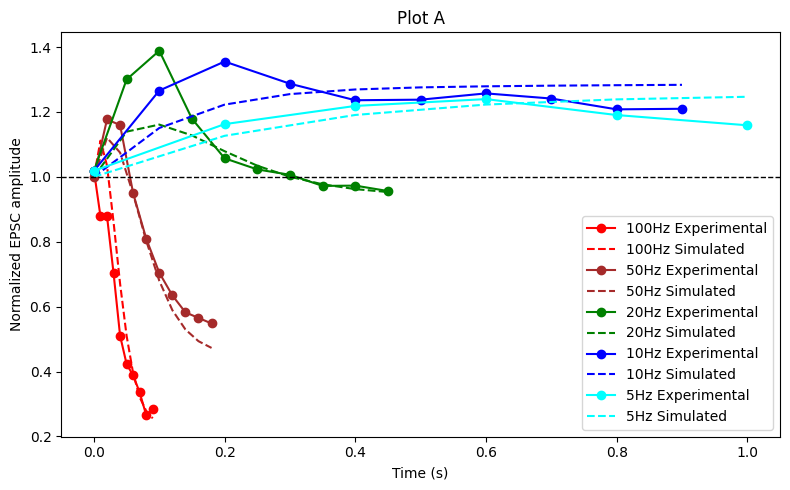

In [22]:
markram_plot(plotA, "Plot A", plotA_params)

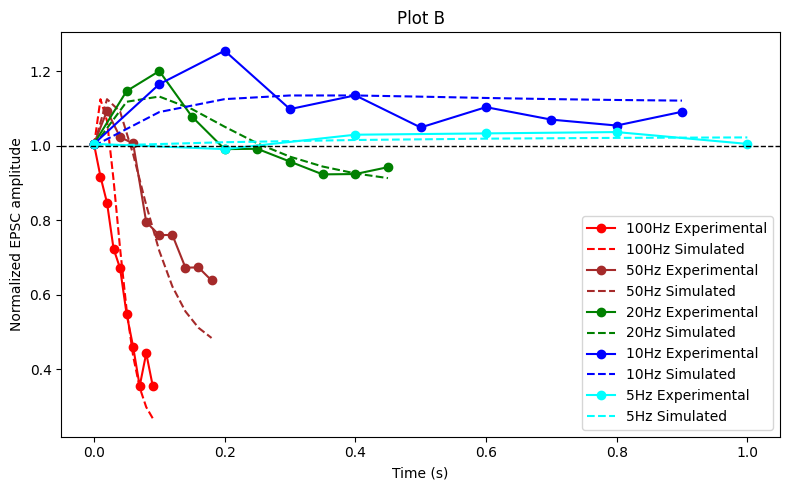

In [23]:
markram_plot(plotB, "Plot B", plotB_params)

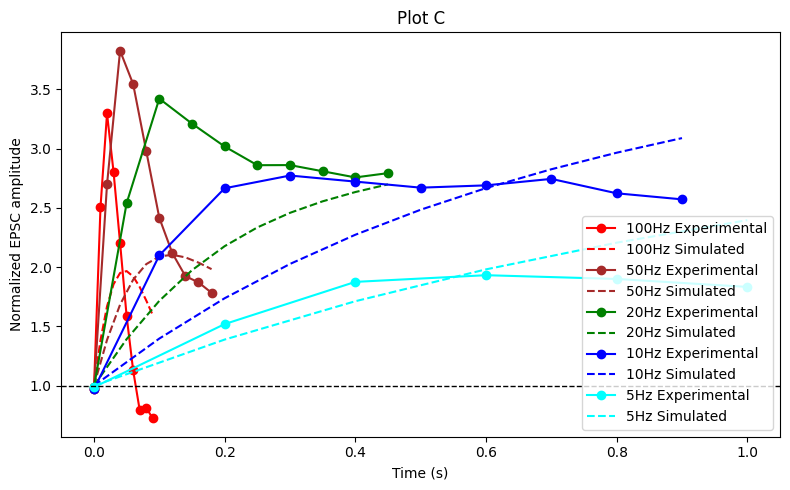

In [24]:
markram_plot(plotC, "Plot C", plotC_params)

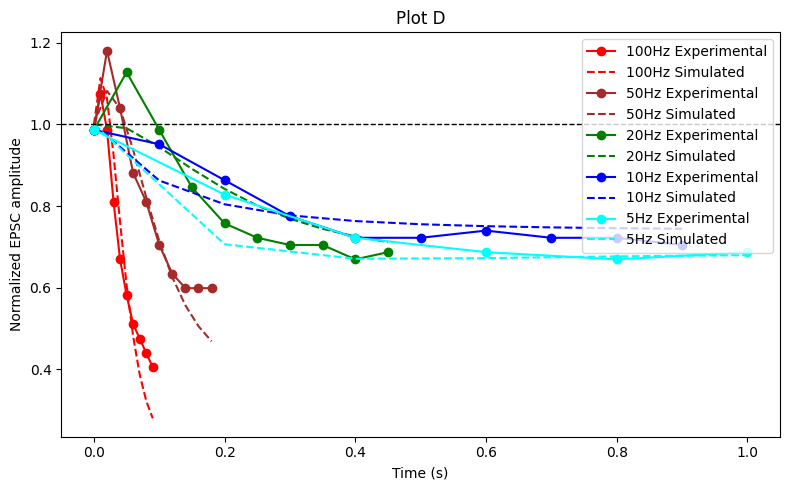

In [25]:
markram_plot(plotD, "Plot D", plotD_params)

In [26]:
from multiprocessing import Pool

def run_algorithm_with_seed(args):
    """
    Wrapper function for running algorithm with specific seed.

    This helper function unpacks arguments for parallel processing with
    multiprocessing.Pool.map(). It extracts the plot data and seed from
    a tuple and calls run_algorithm with fixed hyperparameters.

    Parameters
    ----------
    args : tuple
        Tuple containing (plot, seed) where:
            - plot : dict
                Experimental data dictionary
            - seed : int
                Random seed for this run
            - n : int, optional
                Number of top individuals to return (default: 1)

    Returns
    -------
    results : list
        best_ind : deap.creator.Individual
        Best individual found in this optimization run

    Notes
    -----
    This function uses fixed hyperparameters:
        - NIND = 200
        - NGEN = 100
        - CXPB = 0.7
        - MUTPB = 0.2

    See Also
    --------
    parallel_run : Main function that uses this wrapper
    run_algorithm : The underlying optimization function
    """
    plot, seed, n = args
    return run_algorithm(plot, n=n, NIND=200, NGEN=100, CXPB=0.7, MUTPB=0.2, seed=seed)

In [31]:
def parallel_run(plot, seeds, n=1, n_processes=None):
    """
    Run genetic algorithm optimization in parallel with multiple seeds.

    Executes multiple independent optimization runs using different random seeds
    in parallel. This approach helps find more robust parameter estimates by
    exploring different regions of the parameter space and avoiding local minima.

    Parameters
    ----------
    plot : dict
        Dictionary of experimental data where keys are condition labels
        and values are pandas DataFrames with 'Time(s)' and 'Norm EPSC amp' columns.

    seeds : list of int
        List of random seeds to use for parallel runs.
        Example: [42, 123, 456, 789, 1011]

    n : int, optional
        Number of top individuals to return from EACH seed (default: 1)

    n_processes : int, optional
        Number of parallel processes to use. If None, uses as many processes
        as there are seeds (default: None). Set to a smaller number to limit
        CPU usage.

    Returns
    -------
    results : list
        If n=1: List of best individuals (one per seed)
        If n>1: List of lists, where each inner list contains top n individuals from one seed.

    Notes
    -----
    - Uses Python's multiprocessing.Pool for parallelization
    - All runs use the same hyperparameters (NIND=200, NGEN=100, CXPB=0.7, MUTPB=0.2)
    - Each process is independent and doesn't share information
    - Consider using select_best_individual() to choose the overall best result

    Examples
    --------
    >>> import pandas as pd
    >>> data = {
    ...     '10Hz': pd.DataFrame({
    ...         'Time(s)': [0, 0.1, 0.2],
    ...         'Norm EPSC amp': [1.0, 1.1, 1.05]
    ...     })
    ... }
    >>> # Run 5 independent optimizations with different seeds
    >>> seeds = [42, 123, 456, 789, 1011]
    >>> results = parallel_run(data, seeds, n_processes=5)
    >>> # Find the best result across all runs
    >>> best = select_best_individual(results)
    >>> print(f"Best parameters: {best}")
    >>> print(f"Best fitness: {best.fitness.values[0]:.6f}")

    See Also
    --------
    select_best_individual : Select best result from multiple runs
    run_algorithm : Single optimization run
    """
    if n_processes is None:
        n_processes = len(seeds)

    with Pool(processes=n_processes) as pool:
        results = pool.map(run_algorithm_with_seed, [(plot, seed, n) for seed in seeds])

    return results

In [32]:
def select_best_individual(individuals):
    """
    Select the individual with the lowest fitness value from a list.

    Given multiple DEAP individuals (typically from parallel optimization runs),
    returns the one with the best (lowest) fitness value. This is useful for
    finding the best result across multiple independent optimization runs.

    Parameters
    ----------
    individuals : list of deap.creator.Individual
        List of individuals to compare. Each individual must have a fitness
        attribute with a values tuple.

    Returns
    -------
    best_ind : deap.creator.Individual
        The individual with the lowest fitness value.
        Contains optimized parameters [U, tau_rec, tau_facil].

    Notes
    -----
    - Assumes minimization objective (lower fitness is better)
    - Fitness is accessed via individual.fitness.values[0]
    - If multiple individuals have the same fitness, returns the first one found

    Examples
    --------
    >>> # After running parallel optimization
    >>> seeds = [42, 123, 456, 789, 1011]
    >>> results = parallel_run(data, seeds)
    >>>
    >>> # Select the best result
    >>> best = select_best_individual(results)
    >>> U, tau_rec, tau_facil = best
    >>>
    >>> print(f"Best parameters:")
    >>> print(f"  U = {U:.4f}")
    >>> print(f"  tau_rec = {tau_rec:.2f} ms")
    >>> print(f"  tau_facil = {tau_facil:.2f} ms")
    >>> print(f"  MSE = {best.fitness.values[0]:.6f}")
    >>>
    >>> # Compare all results
    >>> for i, ind in enumerate(results):
    ...     print(f"Seed {seeds[i]}: MSE = {ind.fitness.values[0]:.6f}")

    See Also
    --------
    parallel_run : Run multiple optimizations in parallel
    """
    # Check if we have a list of lists (not a list of Individuals)
    if individuals and isinstance(individuals[0], list) and not hasattr(individuals[0], 'fitness'):
        individuals = [ind for sublist in individuals for ind in sublist]

    best = min(individuals, key=lambda ind: ind.fitness.values[0])
    return best

In [33]:
def select_top_n_individuals(individuals, n=10, seeds=None):
    """
    Select the top N individuals with the lowest fitness values.

    Parameters
    ----------
    individuals : list
        List of DEAP individuals OR list of lists of individuals

    n : int, optional
        Number of top individuals to select (default: 10)

    seeds : list of int, optional
        List of seeds used (for display purposes). If provided and individuals
        is a list of lists, will show which seed produced the best individual.

    Returns
    -------
    top_n : list
        List of the N best individuals, sorted by fitness (best first)
    """
    # Track if we have nested structure
    is_nested = individuals and isinstance(individuals[0], list) and not hasattr(individuals[0], 'fitness')

    # Create mapping of individuals to seeds if nested and seeds provided
    ind_to_seed = {}
    if is_nested and seeds is not None:
        for seed_idx, sublist in enumerate(individuals):
            for ind in sublist:
                ind_to_seed[id(ind)] = seeds[seed_idx]

    # Flatten if needed
    if is_nested:
        individuals = [ind for sublist in individuals for ind in sublist]

    # Sort and select top n
    sorted_pop = sorted(individuals, key=lambda ind: ind.fitness.values[0])
    n = min(n, len(sorted_pop))
    top_n = sorted_pop[:n]

    # Print results
    if seeds is not None and ind_to_seed:
        best_seed = ind_to_seed.get(id(top_n[0]), "Unknown")
        print(f"\nBest solution came from seed: {best_seed}")
        print(f"\nTop {n} solutions across all seeds:")
        for i, ind in enumerate(top_n, 1):
            seed_info = ind_to_seed.get(id(ind), "Unknown")
            print(f"  {i}. Seed {seed_info}: U={ind[0]:.4f}, tau_rec={ind[1]:.2f}, "
                  f"tau_facil={ind[2]:.2f}, MSE={ind.fitness.values[0]:.6f}")
    else:
        print(f"\nTop {n} solutions:")
        for i, ind in enumerate(top_n, 1):
            print(f"  {i}. U={ind[0]:.4f}, tau_rec={ind[1]:.2f}, "
                  f"tau_facil={ind[2]:.2f}, MSE={ind.fitness.values[0]:.6f}")

    return top_n

In [34]:
seeds = [1, 42, 123, 7, 99]
plotA_params_seeds = parallel_run(plotA, seeds)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in s

Best parameters: [0.08491250520077788, 337.9827395391885, 410.7068908188545]
Best parameters: [0.09101869248830532, 304.3140277228867, 368.3918234326543]
Best parameters: [0.0840654205163252, 355.61150094235103, 421.4487702375491]
Best parameters: [0.0852355805920666, 340.57872189298325, 404.28430875801513]
Best parameters: [0.08294395319108427, 359.50750436438545, 425.83082315034255]


In [35]:
plotA_best_seed = select_best_individual(plotA_params_seeds)
plotA_best_seed

[0.09101869248830532, 304.3140277228867, 368.3918234326543]

In [36]:
seeds = [1, 42, 123, 7, 99]
plotB_params_seeds = parallel_run(plotB, seeds)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np

Best parameters: [0.08994227647067601, 269.9288124578552, 227.42166803344185]
Best parameters: [0.08234901390994648, 316.7262822328778, 261.70210740729294]
Best parameters: [0.0830126383607239, 313.98238458631124, 254.8236559017893]
Best parameters: [0.08221773520659682, 329.3839173918402, 262.5249338129269]
Best parameters: [0.07954404837981773, 352.4645174892, 281.3812567776695]


In [37]:
plotB_best_seed = select_best_individual(plotB_params_seeds)
plotB_best_seed

[0.08994227647067601, 269.9288124578552, 227.42166803344185]

In [38]:
seeds = [1, 42, 123, 7, 99]
plotC_params_seeds = parallel_run(plotC, seeds)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])

Best parameters: [0.02600796622635604, 193.42316691380904, 1419.2945488260918]
Best parameters: [0.023620862773296322, 243.56806649894042, 1650.7612969908052]
Best parameters: [0.023574459393975414, 262.0010184780763, 1704.4160274994892]
Best parameters: [0.02490571068427101, 213.42447693029834, 1515.0185076398789]
Best parameters: [0.02146214728504471, 363.8557090868635, 2231.714524489641]


In [39]:
plotC_best_seed = select_best_individual(plotC_params_seeds)
plotC_best_seed

[0.02600796622635604, 193.42316691380904, 1419.2945488260918]

In [40]:
seeds = [1, 42, 123, 7, 99]
plotD_params_seeds = parallel_run(plotD, seeds)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in sc

Best parameters: [0.0759622424380675, 390.0095642211565, 111.93557228579851]
Best parameters: [0.07601485503345018, 388.27104144078186, 111.04885788256777]
Best parameters: [0.06990039459693632, 569.5203346301198, 135.28016114443218]
Best parameters: [0.07462781370759548, 405.0108956696687, 113.33751754531767]
Best parameters: [0.07481379580848295, 404.001936453911, 114.45147522830031]


In [41]:
plotD_best_seed = select_best_individual(plotD_params_seeds)
plotD_best_seed

[0.07601485503345018, 388.27104144078186, 111.04885788256777]

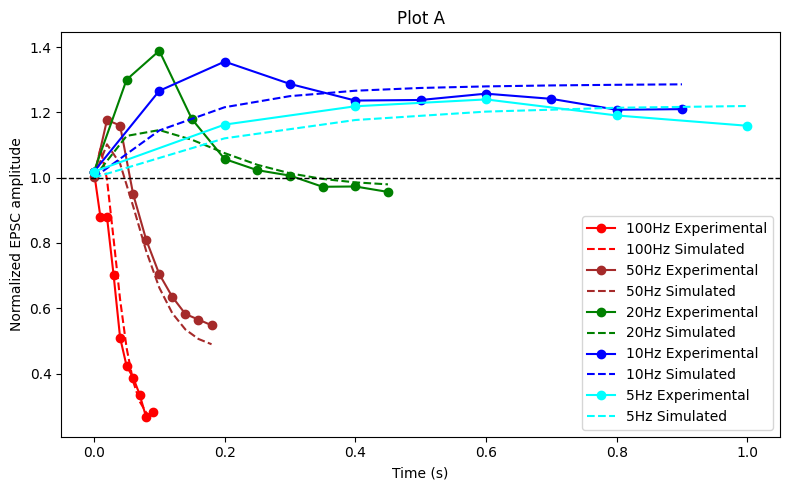

In [42]:
markram_plot(plotA, "Plot A", plotA_best_seed)

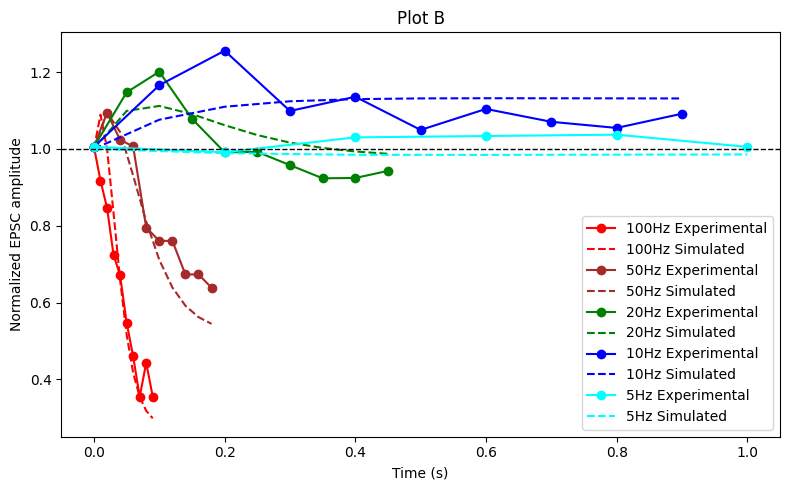

In [43]:
markram_plot(plotB, "Plot B", plotB_best_seed)

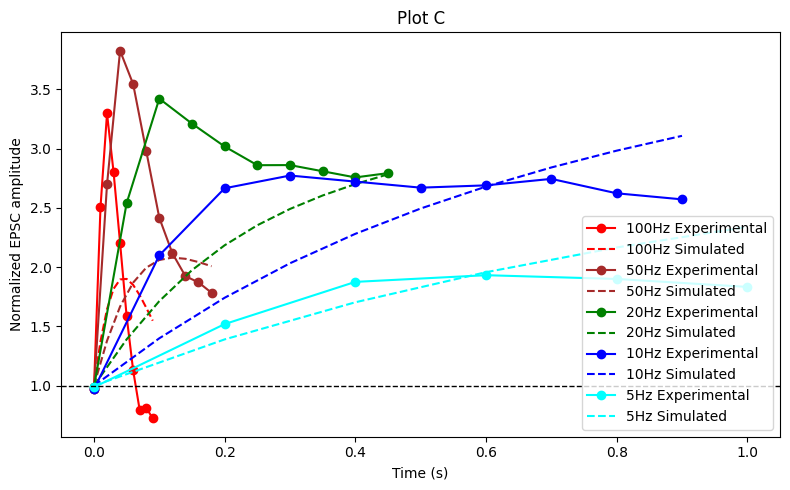

In [44]:
markram_plot(plotC, "Plot C", plotC_best_seed)

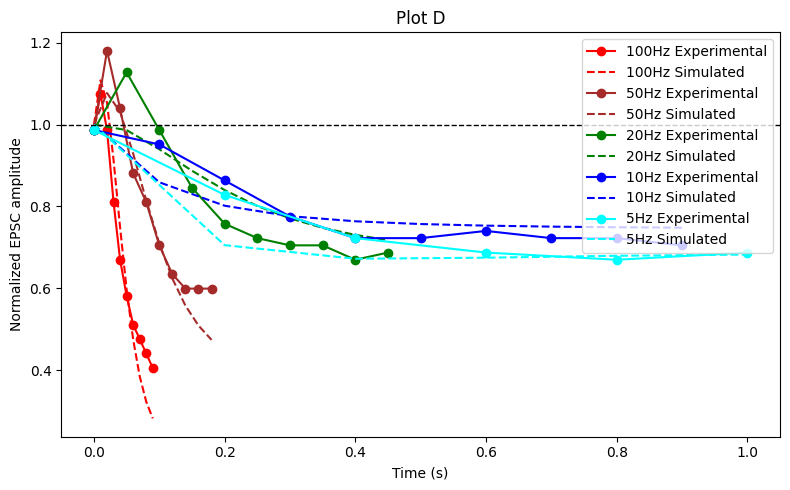

In [45]:
markram_plot(plotD, "Plot D", plotD_best_seed)

In [46]:
# test for top 10 with multiple seeds
seeds = [1, 42, 123, 7, 99]
plotA_params_seeds_10 = parallel_run(plotA, seeds, n=10)

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in s


Top 10 solutions from seed 123:
  1. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  2. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  3. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  4. U=0.0911, tau_rec=304.16, tau_facil=369.49, MSE=0.005733
  5. U=0.0911, tau_rec=304.16, tau_facil=369.49, MSE=0.005733
  6. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  7. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  8. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  9. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  10. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733

Top 10 solutions from seed 1:
  1. U=0.0852, tau_rec=340.58, tau_facil=404.28, MSE=0.006267
  2. U=0.0852, tau_rec=340.58, tau_facil=404.28, MSE=0.006267
  3. U=0.0852, tau_rec=340.58, tau_facil=404.28, MSE=0.006267
  4. U=0.0852, tau_rec=340.58, tau_facil=404.28, MSE=0.006267
  5. U=0.0852, tau_rec=340.66, tau_facil=404.14, MSE=0.006272
  6. 

In [47]:
# test for selecting top 10 for the best seed out of the multiple
plotA_best_seed_10 = select_top_n_individuals(plotA_params_seeds_10)
plotA_best_seed_10


Top 10 solutions:
  1. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  2. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  3. U=0.0910, tau_rec=304.31, tau_facil=368.39, MSE=0.005732
  4. U=0.0911, tau_rec=304.16, tau_facil=369.49, MSE=0.005733
  5. U=0.0911, tau_rec=304.16, tau_facil=369.49, MSE=0.005733
  6. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  7. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  8. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  9. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733
  10. U=0.0913, tau_rec=304.27, tau_facil=369.53, MSE=0.005733


[[0.09101869248830532, 304.3140277228867, 368.3918234326543],
 [0.09101869248830532, 304.3140277228867, 368.3918234326543],
 [0.09101869248830532, 304.3140277228867, 368.3918234326543],
 [0.09112563682874006, 304.15523133654233, 369.4858062853174],
 [0.09112563682874006, 304.15523133654233, 369.4858062853174],
 [0.09132831893081739, 304.26896935527, 369.53353581126737],
 [0.09132831893081739, 304.26896935527, 369.53353581126737],
 [0.09132831893081739, 304.26896935527, 369.53353581126737],
 [0.09132831893081739, 304.26896935527, 369.53353581126737],
 [0.09132831893081739, 304.26896935527, 369.53353581126737]]

In [48]:
# test for selecting the top 10 with one seed
plotA_params_10 = run_algorithm(plotA, n=10)
plotA_params_10


Top 10 solutions from seed 42:
  1. U=0.0849, tau_rec=337.98, tau_facil=410.71, MSE=0.006317
  2. U=0.0849, tau_rec=337.98, tau_facil=410.71, MSE=0.006317
  3. U=0.0849, tau_rec=337.98, tau_facil=410.71, MSE=0.006317
  4. U=0.0876, tau_rec=334.17, tau_facil=424.19, MSE=0.006385
  5. U=0.0876, tau_rec=334.17, tau_facil=424.19, MSE=0.006385
  6. U=0.0846, tau_rec=343.39, tau_facil=415.60, MSE=0.006385
  7. U=0.0846, tau_rec=343.39, tau_facil=415.60, MSE=0.006385
  8. U=0.0866, tau_rec=338.37, tau_facil=423.99, MSE=0.006386
  9. U=0.0866, tau_rec=338.37, tau_facil=423.99, MSE=0.006386
  10. U=0.0866, tau_rec=338.37, tau_facil=423.99, MSE=0.006386


[[0.08491250520077788, 337.9827395391885, 410.7068908188545],
 [0.08491250520077788, 337.9827395391885, 410.7068908188545],
 [0.08491250520077788, 337.9827395391885, 410.7068908188545],
 [0.08762122936791855, 334.1696226538773, 424.19485465074774],
 [0.08762122936791855, 334.1696226538773, 424.19485465074774],
 [0.0846455495125081, 343.39475149197904, 415.60436618238504],
 [0.0846455495125081, 343.39475149197904, 415.60436618238504],
 [0.08662026883520194, 338.37169117117185, 423.98932177186657],
 [0.08662026883520194, 338.37169117117185, 423.98932177186657],
 [0.08662026883520194, 338.37169117117185, 423.98932177186657]]

In [49]:
def evolution(plot, NIND=200, NGEN=100, CXPB=0.7, MUTPB=0.2, seed=42, verbose=True):
    """
    Optimize Markram model parameters using genetic algorithm with statistics tracking.

    Uses DEAP's built-in eaSimple algorithm to find optimal parameters (U, tau_rec,
    tau_facil) that minimize the mean squared error between model predictions
    and experimental EPSC data. Unlike run_algorithm, this function provides
    detailed statistics and logging throughout the optimization process.

    Parameters
    ----------
    plot_data : dict
        Dictionary of experimental data. Keys are condition labels, values are
        DataFrames with 'Time(s)' and 'Norm EPSC amp' columns.

    NIND : int, optional
        Population size (default: 200)

    NGEN : int, optional
        Number of generations (default: 100)

    CXPB : float, optional
        Crossover probability (default: 0.7)

    MUTBP : float, optional
        Mutation probability (default: 0.2)

    verbose : bool, optional
        If True, print progress during optimization (default: True)

    Returns
    -------
    best_params : tuple
        Optimized parameters (U, tau_rec, tau_facil)

    best_fitness : float
        Final fitness value (MSE) of the best parameters

    population : list
        Final population of individuals

    logbook : deap.tools.Logbook
        Statistics logged during evolution (avg, std, min, max fitness per generation)

    Examples
    --------
    >>> import pandas as pd
    >>> data = {
    ...     '10Hz': pd.DataFrame({'Time(s)': [0, 0.1, 0.2],
    ...                           'Norm EPSC amp': [1.0, 1.1, 1.05]})
    ... }
    >>> best_params, best_fitness, pop, log = optimize_markram_parameters(data)
    >>> print(f"Best parameters: U={best_params[0]:.3f}, "
    ...       f"tau_rec={best_params[1]:.1f}, tau_facil={best_params[2]:.1f}")
    >>> print(f"Final MSE: {best_fitness:.6f}")

    See Also
    --------
    run_algorithm : Simpler optimization without detailed statistics
    parallel_run : Run multiple optimizations with different seeds
    """
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)

    # Setup toolbox
    tb = toolbox()

    # Register the evaluation function with the data
    tb.register("evaluate", lambda ind: (fitness_markram(ind, plot),))

    # Create initial population
    pop = tb.population(n=NIND)

    # Statistics to track
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("best", np.min)
    stats.register("worst", np.max)

    # Run the algorithm
    pop, logbook = algorithms.eaSimple(pop, tb, cxpb=CXPB, mutpb=MUTPB,
                                        ngen=NGEN, stats=stats,
                                        verbose=verbose)

    # Get the best individual
    best_ind = tools.selBest(pop, 1)[0]

    print(f"\nSeed {seed} - Best parameters: {best_ind}")
    print(f"Seed {seed} - Best fitness: {best_ind.fitness.values[0]:.6f}")

    return tuple(best_ind), best_ind.fitness.values[0], pop, logbook

In [50]:
best_paramsA, best_fitnessA, popA, logbookA = evolution(plotA)

gen	nevals	avg        	std        	best     	worst      
0  	200   	8.80087e+14	1.24151e+16	0.0485213	1.76017e+17
1  	154   	1.24715e+11	1.75932e+12	0.0459608	2.4943e+13 
2  	150   	inf        	nan        	0.0459608	inf        


/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


3  	160   	2.52692e+13	3.56449e+14	0.0362906	5.0536e+15 
4  	139   	1.6009e+13 	2.25834e+14	0.0362906	3.2018e+15 
5  	143   	2.99173e+19	4.22035e+20	0.0302585	5.98345e+21
6  	146   	8.79394e+16	1.24054e+18	0.0352532	1.75879e+19
7  	162   	3.71191e+168	inf        	0.0269713	7.42382e+170
8  	163   	4.61125e+11 	6.50417e+12	0.0296158	9.22138e+13 


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


9  	144   	2.60404e+15 	3.67345e+16	0.0298279	5.20809e+17 
10 	155   	3.3846e+53  	4.77457e+54	0.0247967	6.76921e+55 
11 	139   	0.0679546   	0.263604   	0.0220385	3.75536     
12 	151   	4.75567e+43 	6.7087e+44 	0.0189647	9.51135e+45 
13 	166   	1.19054e+16 	1.62742e+17	0.0190739	2.30647e+18 
14 	156   	2.47591e+13 	3.4927e+14 	0.0188466	4.95181e+15 
15 	141   	1.68913e+20 	2.38281e+21	0.0172381	3.37826e+22 
16 	149   	1.53374e+12 	2.1636e+13 	0.0167946	3.06747e+14 
17 	170   	2370.34     	33437.5    	0.014288 	474064      
18 	159   	7.96795e+13 	1.12402e+15	0.014288 	1.59359e+16 
19 	149   	9.16029e+16 	1.29222e+18	0.0132202	1.83206e+19 
20 	138   	5.82121e+15 	8.21182e+16	0.0130486	1.16424e+18 
21 	148   	22648.5     	299701     	0.0127492	4.24066e+06 
22 	157   	4.19015e+10 	5.91094e+11	0.0123288	8.38031e+12 
23 	156   	89710       	1.26492e+06	0.0122682	1.79337e+07 
24 	167   	1.29242     	16.9951    	0.0118059	240.571     
25 	151   	1307.51     	18444.5    	0.0115586	261500    

In [51]:
def fitness_vs_generation(logbook, seed=None, plot_name=None, figsize=(10, 6)):
    """
    Plot fitness evolution over generations for a single seed run.

    Shows best, average, and worst fitness across generations with standard
    deviation shading for the population average.

    Parameters
    ----------
    logbook : deap.tools.Logbook
        Logbook from a single evolution run

    seed : int, optional
        Seed number to display in title

    plot_name : str, optional
        Name of the plot/experiment to display in title (e.g., 'plotA')

    figsize : tuple, optional
        Figure size (default: (10, 6))

    Examples
    --------
    >>> # Single seed run
    >>> best_params, best_fitness, pop, logbook = evolution(plotA, seed=42, NGEN=100)
    >>> fitness_vs_generation_single_seed(logbook, seed=42, plot_name='plotA')
    """
    # Extract data from logbook
    generations = logbook.select("gen")
    best_fitness = logbook.select("best")
    avg_fitness = logbook.select("avg")
    worst_fitness = logbook.select("worst")
    std_fitness = logbook.select("std")

    # Create plot
    plt.figure(figsize=figsize)

    # Plot best fitness
    plt.plot(generations, best_fitness, 'b-', linewidth=2, label='Best')

    # Plot average fitness with std deviation shading
    avg = np.array(avg_fitness)
    std = np.array(std_fitness)
    plt.plot(generations, avg, 'g-', linewidth=2, label='Average')
    plt.fill_between(generations, avg - std, avg + std, alpha=0.3, color='green', label='±1 Std Dev')

    # Plot worst fitness
    plt.plot(generations, worst_fitness, 'r--', linewidth=1, alpha=0.5, label='Worst')

    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (MSE)', fontsize=12)

    # Build title
    title_parts = []
    if plot_name:
        title_parts.append(plot_name)
    if seed is not None:
        title_parts.append(f'Seed {seed}')

    if title_parts:
        plt.title(f'{" - ".join(title_parts)} - Fitness vs Generation', fontsize=14, fontweight='bold')
    else:
        plt.title('Fitness vs Generation', fontsize=14, fontweight='bold')

    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

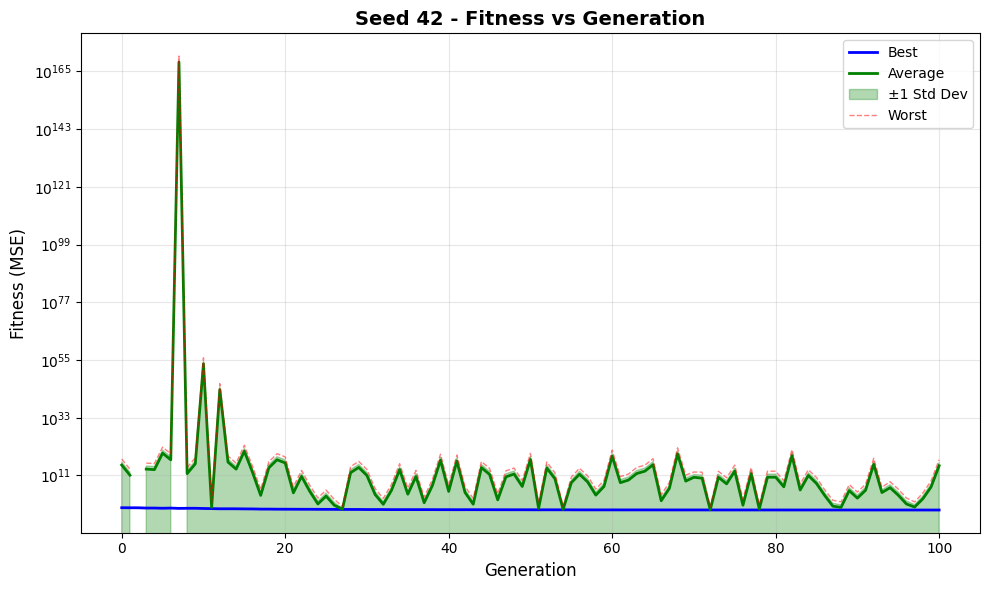

In [52]:
fitness_vs_generation(logbookA, seed=42)

In [53]:
def evolution_seeds(plot, seeds, NIND=200, NGEN=100, CXPB=0.7, MUTPB=0.2, verbose=False):
    """
    Find the best seed from multiple runs and save all logbooks.

    Parameters
    ----------
    plot : dict
        Dictionary of experimental data

    seeds : list of int
        List of random seeds to test

    NIND : int, optional
        Population size (default: 200)

    NGEN : int, optional
        Number of generations (default: 100)

    CXPB : float, optional
        Crossover probability (default: 0.7)

    MUTPB : float, optional
        Mutation probability (default: 0.2)

    verbose : bool, optional
        If True, print detailed progress (default: False)

    Returns
    -------
    results : dict
        Dictionary containing all optimization results:
            - 'best_seed': int, the seed that produced the best result
            - 'best_params': tuple, optimized parameters (U, tau_rec, tau_facil)
            - 'best_fitness': float, best fitness value achieved
            - 'best_logbook': deap.tools.Logbook, logbook from best seed
            - 'seed_results': list of dict, summary of all seed results
            - 'all_logbooks': list, all logbooks from all seeds
    """
    print(f"Testing {len(seeds)} seeds...")
    print("=" * 60)

    # Step 1: Run all seeds and save everything
    seed_results = []
    all_logbooks = []

    for seed in seeds:
        print(f"Testing seed {seed}...", end=" ")

        # Run evolution and get the logbook
        params, fitness, pop, logbook = evolution(
            plot, NIND, NGEN, CXPB, MUTPB, seed, verbose=False
        )

        seed_results.append({
            'seed': seed,
            'fitness': fitness,
            'params': params
        })
        all_logbooks.append(logbook)

        print(f"MSE = {fitness:.6f}")

    # Step 2: Find the best seed
    best_idx = np.argmin([result['fitness'] for result in seed_results])
    best_seed = seed_results[best_idx]['seed']

    print("\n" + "=" * 60)
    print("SEED COMPARISON:")
    print("=" * 60)
    for result in seed_results:
        marker = " ← BEST" if result['seed'] == best_seed else ""
        print(f"Seed {result['seed']}: MSE = {result['fitness']:.6f}{marker}")

    print("\n" + "=" * 60)
    print(f"Best seed: {best_seed}")
    print("=" * 60)

    # Get best results
    best_params = seed_results[best_idx]['params']
    best_fitness = seed_results[best_idx]['fitness']
    best_logbook = all_logbooks[best_idx]

    # Return as dictionary
    return {
        'best_seed': best_seed,
        'best_params': best_params,
        'best_fitness': best_fitness,
        'best_logbook': best_logbook,
        'seed_results': seed_results,
        'all_logbooks': all_logbooks
    }

In [54]:
seeds = [42, 123, 456, 789, 1011]
resultsA = evolution_seeds(plotA,seeds)

Testing 5 seeds...
Testing seed 42... 

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)



Seed 42 - Best parameters: [0.08548127551173021, 348.8374743871194, 413.7297651216263]
Seed 42 - Best fitness: 0.006416
MSE = 0.006416
Testing seed 123... 

/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))



Seed 123 - Best parameters: [0.08165350992486908, 367.1827544446463, 427.9158383207209]
Seed 123 - Best fitness: 0.006905
MSE = 0.006905
Testing seed 456... 
Seed 456 - Best parameters: [0.08598433190136617, 339.894550853452, 416.94926098647693]
Seed 456 - Best fitness: 0.006314
MSE = 0.006314
Testing seed 789... 
Seed 789 - Best parameters: [0.0836788790693476, 360.8496163032889, 421.77734072108575]
Seed 789 - Best fitness: 0.006684
MSE = 0.006684
Testing seed 1011... 
Seed 1011 - Best parameters: [0.08890189496858855, 315.876098903718, 379.721058674573]
Seed 1011 - Best fitness: 0.005858
MSE = 0.005858

SEED COMPARISON:
Seed 42: MSE = 0.006416
Seed 123: MSE = 0.006905
Seed 456: MSE = 0.006314
Seed 789: MSE = 0.006684
Seed 1011: MSE = 0.005858 ← BEST

Best seed: 1011


In [55]:
def fitness_vs_generation_seeds(results, plot_name=None, figsize=(10, 6)):
    """
    Plot fitness evolution over generations for a single experiment with multiple seeds.

    Shows average fitness across seeds with standard deviation, plus individual
    seed trajectories.

    Parameters
    ----------
    results : dict
        Results dictionary from evolution_seeds containing:
            - 'best_seed': best seed number
            - 'seed_results': list of all seed results
            - 'all_logbooks': list of all logbooks

    plot_name : str, optional
        Name of the plot to display in title (e.g., 'plotA')

    figsize : tuple, optional
        Figure size (default: (10, 6))

    Examples
    --------
    >>> seeds = [42, 123, 456, 789, 1011]
    >>> resultsA = evolution_seeds(plotA, seeds, NGEN=100)
    >>> fitness_vs_generation(resultsA, plot_name='plotA')
    """

    # Unpack results
    best_seed = results['best_seed']
    seed_comparison = results['seed_results']
    all_logbooks = results['all_logbooks']

    seeds = [result['seed'] for result in seed_comparison]

    # Extract fitness histories from all seeds
    fitness_histories = []
    for logbook in all_logbooks:
        best_fitness_history = logbook.select("best")
        fitness_histories.append(best_fitness_history)

    # Get maximum length
    max_len = max(len(history) for history in fitness_histories)

    # Pad shorter histories
    padded_histories = []
    for history in fitness_histories:
        if len(history) < max_len:
            padded = list(history) + [history[-1]] * (max_len - len(history))
        else:
            padded = list(history)
        padded_histories.append(padded)

    # Calculate average and std
    avg_fitness = np.mean(padded_histories, axis=0)
    std_fitness = np.std(padded_histories, axis=0)
    generations = np.arange(len(avg_fitness))

    # Create plot
    plt.figure(figsize=figsize)

    # Plot average with shaded std
    plt.plot(generations, avg_fitness, 'b-', linewidth=2, label='Average')
    plt.fill_between(generations, avg_fitness - std_fitness, avg_fitness + std_fitness,
                    alpha=0.3, color='blue', label='±1 Std Dev')

    # Plot individual seeds
    for i, history in enumerate(fitness_histories):
        label = f'Seed {seeds[i]}'
        if seeds[i] == best_seed:
            label += ' (Best)'
        plt.plot(range(len(history)), history, alpha=0.4, linestyle='--', label=label)

    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (MSE)', fontsize=12)

    if plot_name:
        plt.title(f'{plot_name} - Fitness vs Generation', fontsize=14, fontweight='bold')
    else:
        plt.title('Fitness vs Generation', fontsize=14, fontweight='bold')

    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

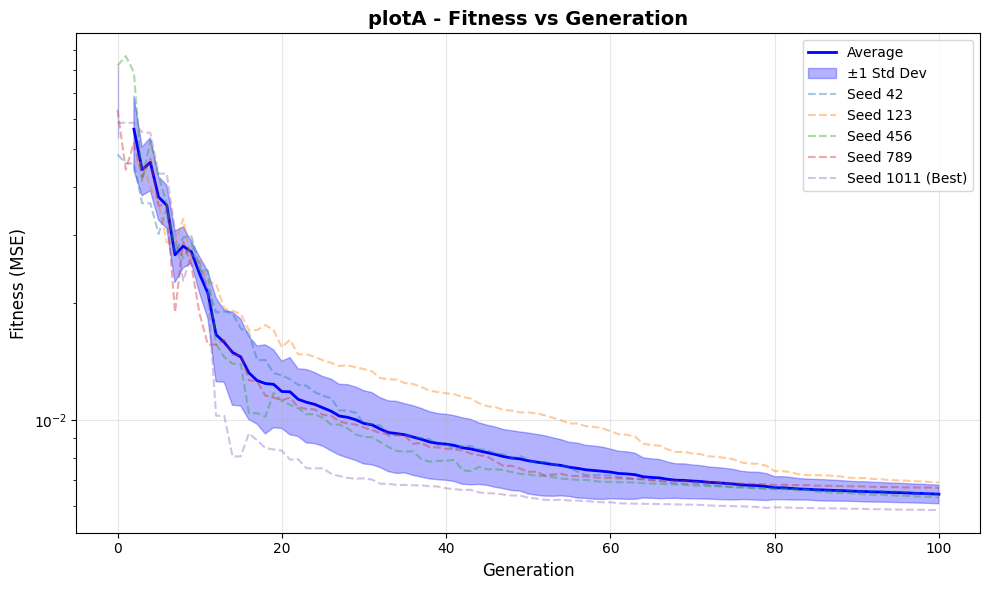

In [56]:
fitness_vs_generation_seeds(resultsA, plot_name='plotA')

In [57]:
seeds = [42, 123, 456, 789, 1011]
resultsB = evolution_seeds(plotB, seeds)

Testing 5 seeds...
Testing seed 42... 

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Seed 42 - Best parameters: [0.07718624153580933, 383.06371834547593, 291.5206031356384]
Seed 42 - Best fitness: 0.006806
MSE = 0.006806
Testing seed 123... 

/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))



Seed 123 - Best parameters: [0.08437805077538785, 310.83898695913814, 249.55237015845813]
Seed 123 - Best fitness: 0.005200
MSE = 0.005200
Testing seed 456... 

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



Seed 456 - Best parameters: [0.08325635773671271, 316.5280835615057, 262.9142772116587]
Seed 456 - Best fitness: 0.005373
MSE = 0.005373
Testing seed 789... 
Seed 789 - Best parameters: [0.08598620602919861, 296.01959048147165, 243.30400765525087]
Seed 789 - Best fitness: 0.004967
MSE = 0.004967
Testing seed 1011... 
Seed 1011 - Best parameters: [0.0851542837750302, 302.3739214634326, 250.17821494022803]
Seed 1011 - Best fitness: 0.005075
MSE = 0.005075

SEED COMPARISON:
Seed 42: MSE = 0.006806
Seed 123: MSE = 0.005200
Seed 456: MSE = 0.005373
Seed 789: MSE = 0.004967 ← BEST
Seed 1011: MSE = 0.005075

Best seed: 789


In [58]:
seeds = [42, 123, 456, 789, 1011]
resultsC = evolution_seeds(plotC, seeds)

Testing 5 seeds...
Testing seed 42... 
Seed 42 - Best parameters: [0.02210093700289524, 330.86531762719784, 2078.4304116076432]
Seed 42 - Best fitness: 0.580224
MSE = 0.580224
Testing seed 123... 

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Seed 123 - Best parameters: [0.02168436183530171, 347.4932943062037, 2099.225243758825]
Seed 123 - Best fitness: 0.581270
MSE = 0.581270
Testing seed 456... 

/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in exp
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: invalid value encountered in scalar subtract
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)



Seed 456 - Best parameters: [0.027777983072883223, 164.27347856929467, 1286.7164242495978]
Seed 456 - Best fitness: 0.566597
MSE = 0.566597
Testing seed 789... 
Seed 789 - Best parameters: [0.024410815497418442, 231.87720981124053, 1556.434183910445]
Seed 789 - Best fitness: 0.572796
MSE = 0.572796
Testing seed 1011... 

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



Seed 1011 - Best parameters: [0.022502066865466963, 297.4880930759957, 1871.197295982874]
Seed 1011 - Best fitness: 0.578017
MSE = 0.578017

SEED COMPARISON:
Seed 42: MSE = 0.580224
Seed 123: MSE = 0.581270
Seed 456: MSE = 0.566597 ← BEST
Seed 789: MSE = 0.572796
Seed 1011: MSE = 0.578017

Best seed: 456


In [59]:
seeds = [42, 123, 456, 789, 1011]
resultsD = evolution_seeds(plotD, seeds)

Testing 5 seeds...
Testing seed 42... 

/tmp/ipython-input-3374482653.py:120: RuntimeWarning: overflow encountered in square
  diff = np.mean((sim_epsc_amps - exp_epsc_amps) ** 2)
/tmp/ipython-input-3374482653.py:63: RuntimeWarning: overflow encountered in scalar multiply
  EPSC[i] = R[i] * u[i]
/tmp/ipython-input-3374482653.py:62: RuntimeWarning: overflow encountered in scalar multiply
  R[i] = R[i-1]*(1 - u[i])*np.exp(-dt[i]/tau_rec) + 1 - np.exp(-dt[i]/tau_rec)
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in scalar multiply
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))
/tmp/ipython-input-3374482653.py:61: RuntimeWarning: overflow encountered in exp
  u[i] = u[i-1]*np.exp(-dt[i]/tau_facil) + U*(1 - u[i-1]*np.exp(-dt[i]/tau_facil))



Seed 42 - Best parameters: [0.07518140719007507, 397.87291365647405, 112.92955253903858]
Seed 42 - Best fitness: 0.003989
MSE = 0.003989
Testing seed 123... 
Seed 123 - Best parameters: [0.07599668162605455, 383.6809562616605, 111.00410763401428]
Seed 123 - Best fitness: 0.003942
MSE = 0.003942
Testing seed 456... 
Seed 456 - Best parameters: [0.07482847909383508, 400.3739914810811, 114.92337615465937]
Seed 456 - Best fitness: 0.004024
MSE = 0.004024
Testing seed 789... 
Seed 789 - Best parameters: [0.07648469176880915, 378.5681933659332, 110.43378840739814]
Seed 789 - Best fitness: 0.003928
MSE = 0.003928
Testing seed 1011... 
Seed 1011 - Best parameters: [0.07562445335427405, 394.4881762720305, 112.17394809822804]
Seed 1011 - Best fitness: 0.003972
MSE = 0.003972

SEED COMPARISON:
Seed 42: MSE = 0.003989
Seed 123: MSE = 0.003942
Seed 456: MSE = 0.004024
Seed 789: MSE = 0.003928 ← BEST
Seed 1011: MSE = 0.003972

Best seed: 789


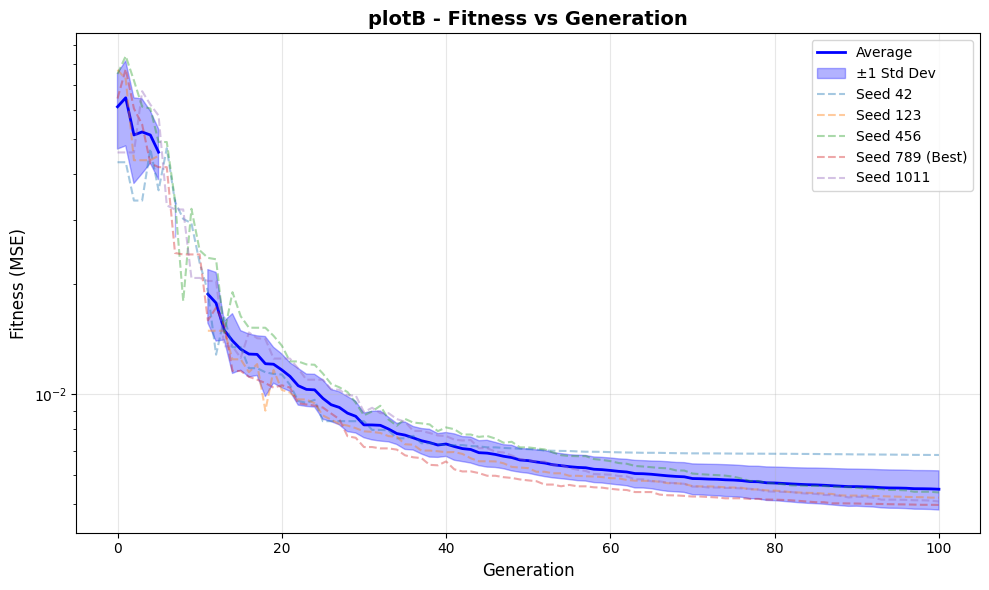

In [60]:
fitness_vs_generation_seeds(resultsB, plot_name='plotB')

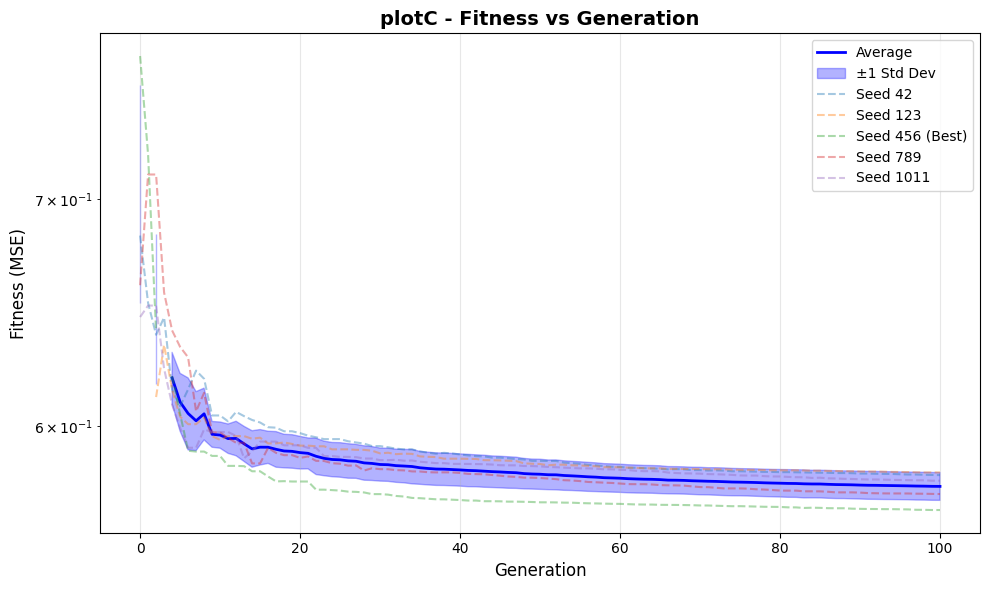

In [61]:
fitness_vs_generation_seeds(resultsC, plot_name='plotC')

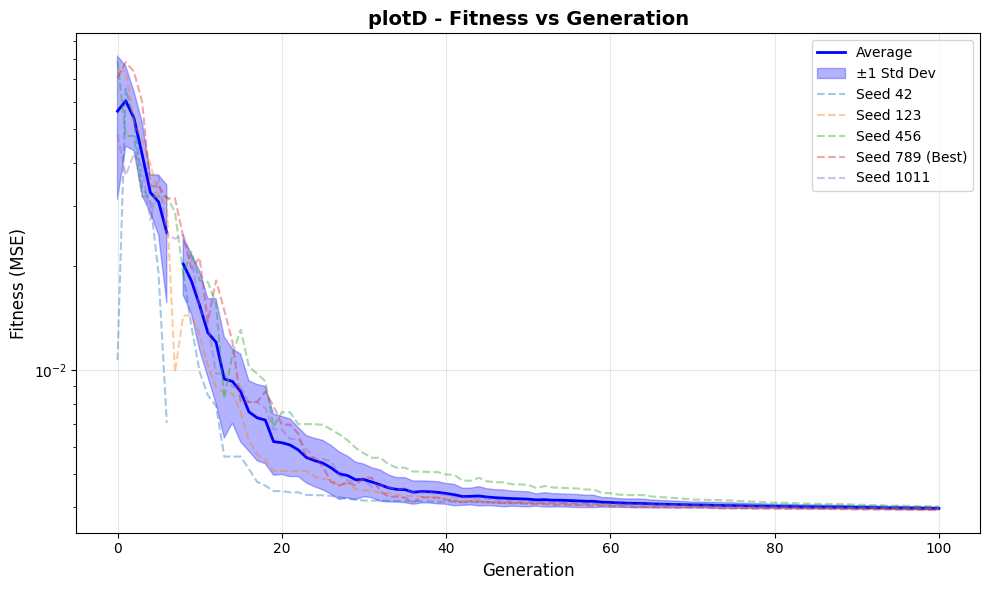

In [62]:
fitness_vs_generation_seeds(resultsD, plot_name='plotD')